In [1]:
from IPython import display
%matplotlib inline
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf
import time
import torch

from torch import nn as nn
import torch.nn.functional as F

import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util

import tactile_gym.rl_envs
from tactile_gym.sb3_helpers.params import import_parameters

%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Load the environment 
algo_name = 'ppo'
env_name = 'object_push-v0'
rl_params, algo_params, augmentations = import_parameters(env_name, algo_name)
rl_params["max_ep_len"] = 1000    
rl_params["env_modes"][ 'observation_mode'] = 'tactile_pose_relative_data'
rl_params["env_modes"][ 'control_mode'] = 'TCP_position_control'
rl_params["env_modes"]['movement_mode'] = 'TyRz'
rl_params["env_modes"]['traj_type'] = 'point'
rl_params["env_modes"]['task'] = "goal_pos"
rl_params["env_modes"]['planar_states'] = True
rl_params["env_modes"]['use_contact'] = True
rl_params["env_modes"]['terminate_early']  = True
rl_params["env_modes"]['terminate_terminate_early'] = True

rl_params["env_modes"]['rand_init_orn'] = True
# rl_params["env_modes"]['rand_init_pos_y'] = True
# rl_params["env_modes"]['rand_obj_mass'] = True

rl_params["env_modes"]['additional_reward_settings'] = 'john_guide_off_normal'
rl_params["env_modes"]['terminated_early_penalty'] =  -500
rl_params["env_modes"]['reached_goal_reward'] = 100
rl_params["env_modes"]['max_no_contact_steps'] = 40
rl_params["env_modes"]['max_tcp_to_obj_orn'] = 30/180 * np.pi
rl_params["env_modes"]['importance_obj_goal_pos'] = 1.0
rl_params["env_modes"]['importance_obj_goal_orn'] = 1.0
rl_params["env_modes"]['importance_tip_obj_orn'] = 1.0

rl_params["env_modes"]['mpc_goal_orn_update'] = True
rl_params["env_modes"]['goal_orn_update_freq'] = 'every_step'


# set limits and goals
TCP_lims = np.zeros(shape=(6, 2))
TCP_lims[0, 0], TCP_lims[0, 1] = -0.1, 0.4  # x lims
TCP_lims[1, 0], TCP_lims[1, 1] = -0.3, 0.3  # y lims
TCP_lims[2, 0], TCP_lims[2, 1] = -0.0, 0.0  # z lims
TCP_lims[3, 0], TCP_lims[3, 1] = -0.0, 0.0  # roll lims
TCP_lims[4, 0], TCP_lims[4, 1] = -0.0, 0.0  # pitch lims
TCP_lims[5, 0], TCP_lims[5, 1] = -180 * np.pi / 180, 180 * np.pi / 180  # yaw lims

# goal parameter
goal_edges = [(0, -1), (0, 1), (1, 0)] # Top bottom and stright
# goal_edges = [(1, 0)]
goal_x_max = np.float64(TCP_lims[0, 1] * 0.8).item()
goal_x_min = 0.0 # np.float64(TCP_lims[0, 0] * 0.6).item()
goal_y_max = np.float64(TCP_lims[1, 1] * 0.6).item()
goal_y_min = np.float64(TCP_lims[1, 0] * 0.6).item()
goal_ranges = [goal_x_min, goal_x_max, goal_y_min, goal_y_max]

rl_params["env_modes"]['tcp_lims'] = TCP_lims.tolist()
rl_params["env_modes"]['goal_edges'] = goal_edges
rl_params["env_modes"]['goal_ranges'] = goal_ranges

env_kwargs={
    'show_gui':False,
    'show_tactile':False,
    'states_stacked_len': 4,
    'max_steps':rl_params["max_ep_len"],
    'image_size':rl_params["image_size"],
    'env_modes':rl_params["env_modes"],
}

# training environment
env = gym.make(env_name, **env_kwargs)
seed = 0
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape
history_len = env.states_stacked_len
step_obs_shape = (obs_shape[-1], )
step_act_shape = act_shape
stacked_obs_shape = (obs_shape[-1] * history_len, )
stacked_act_shape = (history_len * act_shape[-1], )

pybullet build time: Mar  8 2021 17:26:24


argv[0]=
Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 495.29.05
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 495.29.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090/PCIe/SSE2
ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [3]:
print(stacked_obs_shape)
print(stacked_act_shape)

(32,)
(8,)


In [4]:
print(env.reset())
for i in range(4):
    obs, _, done, _ = env.step(env.action_space.sample())
    print(obs.shape)
    # print('latest obs', obs[-1])
    if done:
        break

[[0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
 [0.000870 0.000002 -0.154928 0.987926 0.000000 0.000000 0.154931
  0.987925]]
(4, 8)
(4, 8)
(4, 8)
(4, 8)


In [6]:
trial_length = 1000
num_trials = 10
ensemble_size = 5
buffer_size = 10000
target_normalised = True
using_history_of_obs = True

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "out_size": "???",
        "deterministic": False,
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
        "target_normalize": target_normalised,
        "dataset_size": buffer_size,
        "using_history_of_obs": using_history_of_obs,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 32,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

In [7]:
# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnvPushing(env, dynamics_model, termination_fn=None, reward_fn=None, generator=generator)

/home/qt21590/anaconda3/envs/tactile_gym_mbrl/lib/python3.9/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


In [8]:
print(dynamics_model)

OneDTransitionRewardModel(
  (model): GaussianMLP(
    (hidden_layers): Sequential(
      (0): Sequential(
        (0): EnsembleLinearLayer(num_members=5, in_size=40, out_size=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): EnsembleLinearLayer(num_members=5, in_size=200, out_size=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): EnsembleLinearLayer(num_members=5, in_size=200, out_size=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (mean_and_logvar): EnsembleLinearLayer(num_members=5, in_size=200, out_size=16, bias=True)
  )
)


In [9]:
replay_buffer = common_util.create_replay_buffer(cfg, stacked_obs_shape, stacked_act_shape, rng=rng, next_obs_shape=(obs.shape[-1], ))
common_util.rollout_agent_trajectories(
    env,
    1000, # initial exploration steps
    planning.RandomAgent(env),
    {}, # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length,
    stacking=using_history_of_obs
)

print("# samples stored", replay_buffer.num_stored)

# samples stored 1000


In [10]:
print(replay_buffer.obs.shape)
print(replay_buffer.action.shape)
print(replay_buffer.next_obs.shape)

(10000, 32)
(10000, 8)
(10000, 8)


Training time:  12.548660516738892
Train Loss: -22.78413422902425, Val Loss: 0.7358741164207458


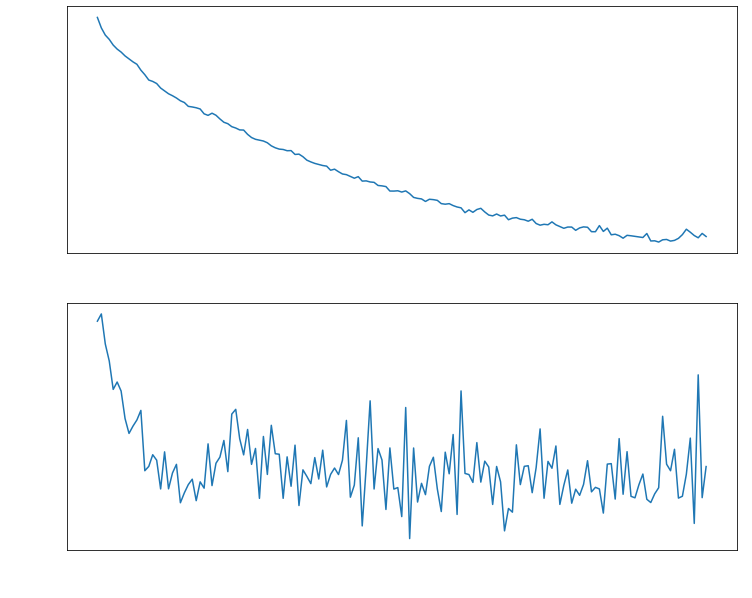

In [11]:
# Test optimisation iterations for CEM
train_losses = []
val_scores = []

def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())   # this returns val score per ensemble model

    
# Train model first
model_trainer = models.ModelTrainer(dynamics_model, optim_lr= 1e-3, weight_decay=5e-5)
dynamics_model.update_normalizer(replay_buffer.get_all())
dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
    replay_buffer,
    batch_size=cfg.overrides.model_batch_size,
    val_ratio=cfg.overrides.validation_ratio,
    ensemble_size=ensemble_size,
    shuffle_each_epoch=True,
    bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
)

start_train_time = time.time()
model_trainer.train(
    dataset_train, 
    dataset_val=dataset_val, 
    num_epochs= 200, 
    patience=50, 
    callback=train_callback,
    silent=True)
train_time = time.time() - start_train_time

print("Training time: ", train_time)
print("Train Loss: {}, Val Loss: {}".format(train_losses[-1], val_scores[-1]))

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(train_losses)
ax[0].set_xlabel("Total training epochs")
ax[0].set_ylabel("Training loss (avg. NLL)")
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[1].plot(val_scores)
ax[1].set_xlabel("Total training epochs")
ax[1].set_ylabel("Validation score (avg. MSE)")
ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
plt.show()

In [12]:
for batch in dataset_train:
    print(batch.obs.shape)
    print(batch.next_obs.shape)

(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 32, 8)
(5, 22, 8)
(5, 22, 8)


In [13]:
for batch in dataset_val:
    print(batch.obs.shape)
    print(batch.next_obs.shape)

(32, 8)
(32, 8)
(18, 8)
(18, 8)


In [14]:
planning_horizon = 15

# Get action sequence from buffer
data = replay_buffer.get_all()
action_sequences = data.act[0:planning_horizon,:]
print(action_sequences.shape)
# print(action_sequences[0])
action_sequences = action_sequences.reshape(*action_sequences.shape[:1], -1)
print(action_sequences.shape)
action_sequences = np.tile(action_sequences, (5,1,1)).astype(np.float32)
action_sequences = torch.from_numpy(action_sequences)
print(action_sequences.shape)

# Initialise state and create model input
initial_state = data.obs[0]
print(initial_state.shape)
initial_state = initial_state.reshape(-1)
print(initial_state.shape)
initial_obs_batch = np.tile(initial_state, (5,1)).astype(np.float32)
print(initial_obs_batch.shape)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)
print(model_state['obs'].shape)


(15, 2)
(15, 2)
torch.Size([5, 15, 2])
(8,)
(8,)
(5, 8)
torch.Size([5, 8])


In [15]:
data.obs.shape

(1000, 8)

In [12]:
# -------- Test model one set of action sequences from buffer to see exploding -------
# states still occur

planning_horizon = 15

# Get action sequence from buffer
data = replay_buffer.get_all()
action_sequences = data.act[0:planning_horizon,:]
# action_sequences = action_sequences.reshape(*action_sequences.shape[:1], -1)
action_sequences = np.tile(action_sequences, (5,1,1)).astype(np.float32)
action_sequences = torch.from_numpy(action_sequences)
# print(action_sequences.shape)

# Initialise state and create model input
initial_state = data.obs[0]
# initial_state = initial_state.reshape(-1)
initial_obs_batch = np.tile(initial_state, (5,1)).astype(np.float32)
# print(initial_obs_batch.shape)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)
# print(model_state['propagation_indices'])


batch_size = initial_obs_batch.shape[0]
# total_rewards = torch.zeros(batch_size, 1)
# terminated = torch.zeros(batch_size, 1, dtype=bool)
model_env.reset_batch_goals(batch_size)

for time_step in range(planning_horizon):

    print(torch.mean(model_state["obs"], 0)[0:3])
    action_for_step = action_sequences[:, time_step, :]
    action_batch = action_sequences[:, time_step, :]

    # ---------------- Use model_env.step -----------------
    # _, rewards, dones, model_state = model_env.step(
    #     action_batch, model_state, sample=True
    # )
    # rewards[terminated] = 0
    # terminated |= dones
    # total_rewards += rewards

    # -------------- Use one_dim_tr_model sample -------------
    with torch.no_grad():
        next_observs, _, _, model_state, = model_env.dynamics_model.sample(
            action_batch, model_state, deterministic=False, rng=model_env._rng,
        )

    # -------------- Use model.sample_1d() --------------------
    # with torch.no_grad():
    #     obs = model_state["obs"]
    #     model_in = model_env.dynamics_model._get_model_input(model_state["obs"], action_batch)
    #     next_observs, _ = model_env.dynamics_model.model.sample_1d(
    #         model_in, model_state, rng=model_env._rng, deterministic=False
    #     )
    #     if model_env.dynamics_model.target_normalizer:
    #         next_observs = model_env.dynamics_model.target_normalizer.denormalize(next_observs)
    #     next_observs += obs[..., -next_observs.shape[-1]:]
    #     model_state["obs"] = torch.cat([model_state["obs"], next_observs], dim=obs.ndim - 1)
    #     model_state["obs"] = model_state["obs"][..., next_observs.shape[-1]:]


        # Check if concat and removing has been done correctly
        # print(model_state["obs"][-1, -8:] == next_observs[-1, :])
        # print(model_state["obs"].shape == obs.shape)


tensor([ 8.6693e-04,  8.9407e-07, -8.9774e-02], device='cuda:0')
tensor([ 8.2699e-04, -1.5664e-05, -9.0519e-02], device='cuda:0')
tensor([ 0.0010,  0.0002, -0.0922], device='cuda:0')
tensor([ 0.0012, -0.0002, -0.0976], device='cuda:0')
tensor([ 0.0011, -0.0002, -0.0997], device='cuda:0')
tensor([ 1.1356e-03,  4.3994e-05, -9.9060e-02], device='cuda:0')
tensor([ 0.0012, -0.0003, -0.1017], device='cuda:0')
tensor([ 0.0012,  0.0002, -0.0974], device='cuda:0')
tensor([ 0.0012,  0.0002, -0.1065], device='cuda:0')
tensor([ 0.0012,  0.0006, -0.1130], device='cuda:0')
tensor([ 0.0013,  0.0004, -0.1192], device='cuda:0')
tensor([ 0.0013,  0.0007, -0.1136], device='cuda:0')
tensor([ 0.0013,  0.0006, -0.1137], device='cuda:0')
tensor([ 0.0015,  0.0008, -0.1115], device='cuda:0')
tensor([ 0.0016,  0.0004, -0.1102], device='cuda:0')


In [12]:
agent_cfg = omegaconf.OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
    "planning_horizon": 15,
    "replan_freq": 1,
    "verbose": False,
    "action_lb": "???",
    "action_ub": "???",
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "mbrl.planning.CEMOptimizer",
        "num_iterations": 5,
        "elite_ratio": 0.1,
        "population_size": 500,
        "alpha": 0.1,
        "device": device,
        "lower_bound": "???",
        "upper_bound": "???",
        "return_mean_elites": True,
        "clipped_normal": False
    }
})

agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=20
)

In [13]:
act = np.zeros(2)
initial_action_batch = np.tile(act, (1000,1)).astype(np.float32)
print(initial_action_batch.shape)

(1000, 2)


In [19]:
planning_horizon = agent.optimizer.horizon

obs = env.reset()
obs = obs.reshape(-1)
act = np.zeros(stacked_act_shape)
agent.reset()
def trajectory_eval_fn(action_sequences):
    return model_env.evaluate_action_sequences(action_sequences, obs, 20, act)

# Create initial solutions from bounds
action_lb = env.action_space.low.tolist()
action_ub = env.action_space.high.tolist()
initial_solution = (
            ((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
            .float().to(device)
        )
initial_solution = initial_solution.repeat((planning_horizon, 1))

# # Create random initial solutions
# initial_solution = torch.from_numpy(np.array([env.action_space.sample() for _ in range(15)])).float()

def cem_callback(population, values, i):
    best_values, elite_idx = values.topk(1)
    print("Iteration {}, best value {}".format(i, best_values))

agent.optimizer.optimizer.num_iterations  = 10
# agent.optimizer.optimizer.elite_ratio =
# agent.optimizer.optimizer.population_size = 

# Optimise
agent.optimizer.optimizer.optimize(
            trajectory_eval_fn,
            x0=initial_solution,
            callback=cem_callback,
        )

Iteration 0, best value tensor([-23.8180], device='cuda:0')
Iteration 1, best value tensor([-23.6649], device='cuda:0')
Iteration 2, best value tensor([-23.4310], device='cuda:0')
Iteration 3, best value tensor([-23.3728], device='cuda:0')
Iteration 4, best value tensor([-23.2821], device='cuda:0')
Iteration 5, best value tensor([-23.2466], device='cuda:0')
Iteration 6, best value tensor([-23.1310], device='cuda:0')
Iteration 7, best value tensor([-23.1205], device='cuda:0')
Iteration 8, best value tensor([-23.0789], device='cuda:0')
Iteration 9, best value tensor([-23.1476], device='cuda:0')


tensor([[-0.0502, -0.2013],
        [-0.0165,  0.0540],
        [-0.1710,  0.0367],
        [-0.1837,  0.0654],
        [-0.1875,  0.0389],
        [-0.1844,  0.1011],
        [-0.1335,  0.0795],
        [-0.1671,  0.0501],
        [-0.1003,  0.0594],
        [-0.1619,  0.0163],
        [-0.0752,  0.0452],
        [-0.1247,  0.0524],
        [-0.0615,  0.0414],
        [-0.0432, -0.0076],
        [ 0.0132,  0.0190]], device='cuda:0')

In [20]:
from collections import deque

obs = env.reset()    
agent.reset()
stacked_act = deque(np.zeros((env.states_stacked_len, *env.action_space.shape)), maxlen=env.states_stacked_len)
print(stacked_act)
next_obs, reward, done, info = common_util.step_env_and_add_to_buffer_stacked(
    env, obs, agent, {}, replay_buffer, stacked_action=stacked_act)
print(stacked_act)

deque([array([0.000000, 0.000000]), array([0.000000, 0.000000]), array([0.000000, 0.000000]), array([0.000000, 0.000000])], maxlen=4)
deque([array([0.000000, 0.000000]), array([0.000000, 0.000000]), array([0.000000, 0.000000]), array([-0.054634, -0.196153], dtype=float32)], maxlen=4)
